In [1]:
import pandas as pd
import numpy as np
import ast

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

Load the steam games dataset

In [2]:
with open('/content/drive/MyDrive/VideoGameRecFiles/steam_games.json','r',encoding='utf8') as f:
  data = f.read()
  data = data.strip().split("\n")
  steam_games = []
  # The steam games dataset is not a properly formatted json file. Because of this we need to iterate through each individual JSON object and use
  # the ast module to parse the object.
  for entry in data:
    game = ast.literal_eval(entry)
    # Convert the genres, tags, and specs field from a string type to a list type
    if 'genres' in game:
      game['genres'] = ','.join(game['genres'])
    else:
      game['genres'] = None
    if 'tags' in game:
      game['tags'] = ','.join(game['tags'])
    else:
      game['tags'] = None
    if 'specs' in game:
      game['specs'] = ','.join(game['specs'])
    else:
      game['specs'] = None
    steam_games.append(game)
  # Create a dataframe
  steam_games_df = pd.DataFrame(steam_games)
  del(steam_games)

Create a dictionary containing sets of games that contain each genre, tag, and spec

In [3]:
# Create a dictionary containing sets of games that have each attribute
category_sets = {}

for idx in range(steam_games_df.shape[0]):
  game_genre = steam_games_df.iloc[idx]['genres']
  game_tags = steam_games_df.iloc[idx]['tags']
  game_specs = steam_games_df.iloc[idx]['specs']
  game_id = steam_games_df.iloc[idx]['id']
  if game_genre:
    cat_genres = game_genre.split(",")
    for g in cat_genres:
      if g in category_sets:
        category_sets[g].add(game_id)
      else:
        category_sets[g] = set([game_id])
  if game_tags:
    cat_tags = game_tags.split(",")
    for t in cat_tags:
      if t in category_sets:
        category_sets[t].add(game_id)
      else:
        category_sets[t] = set([game_id])
  if game_specs:
    cat_specs = game_specs.split(",")
    for s in cat_specs:
      if s in category_sets:
        category_sets[s].add(game_id)
      else:
        category_sets[s] = set([game_id])

Compute a matrix of conditional probabilities for each category. Each cell will contain the conditional probability of observing a game containing a particular attribute

In [4]:
game_categories = list(category_sets.keys())

In [5]:
probability_matrix = []

for g in game_categories:
  prob_list = []
  for c in game_categories:
    game_intersection = category_sets[g].intersection(category_sets[c])
    prob_list.append(len(game_intersection) / len(category_sets[g]))
  probability_matrix.append(prob_list)

In [6]:
probability_matrix = np.array(probability_matrix)

In [7]:
probability_matrix

array([[1.00000000e+00, 2.24245218e-01, 6.27871245e-01, ...,
        1.53645233e-04, 1.53645233e-04, 7.68226166e-05],
       [2.98863520e-01, 1.00000000e+00, 6.68168322e-01, ...,
        2.04771168e-04, 1.02385584e-04, 0.00000000e+00],
       [4.63269471e-01, 3.69912708e-01, 1.00000000e+00, ...,
        1.13365832e-04, 1.13365832e-04, 0.00000000e+00],
       ...,
       [5.00000000e-01, 5.00000000e-01, 5.00000000e-01, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 5.00000000e-01, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [8]:
probability_matrix.shape

(381, 381)

Use Principal Component Analysis to reduce the dimensions of the probability matrix before clustering

In [9]:
pca = PCA()
pca.fit(probability_matrix)

PCA()

Do a running sum of the explained variance ratio for each component

In [10]:
total = 0
for idx, r in enumerate(pca.explained_variance_ratio_):
  total += r
  print("{0} Components: {1}".format(idx, total))

0 Components: 0.11786002656038877
1 Components: 0.2027058639575488
2 Components: 0.27110383867609955
3 Components: 0.3292879412952396
4 Components: 0.37786937197292686
5 Components: 0.41565580593149243
6 Components: 0.44352163310890347
7 Components: 0.46834626401333035
8 Components: 0.48946616530494125
9 Components: 0.5072891342019902
10 Components: 0.5244475457701763
11 Components: 0.5393607246972233
12 Components: 0.5528816056528714
13 Components: 0.5660064757160639
14 Components: 0.5776769755806695
15 Components: 0.5886335588495886
16 Components: 0.5991873660905405
17 Components: 0.6086394757418064
18 Components: 0.6175841401193083
19 Components: 0.6262334626925397
20 Components: 0.6342193863813627
21 Components: 0.641990268587063
22 Components: 0.6493342793484921
23 Components: 0.6562416869750115
24 Components: 0.6630439992818239
25 Components: 0.6693882752447055
26 Components: 0.6754893389545293
27 Components: 0.6812557088999107
28 Components: 0.6866233557372129
29 Components: 0.6

We will keep enough components to explain 70% of the variance in the matrix. That number is 31 so we will go with that! 

In [11]:
# Refit PCA to the probability matrix and keep only the 31 principal components
pca = PCA(n_components=31)
pca.fit(probability_matrix)
feature_set = pca.transform(probability_matrix)

# Clustering Game Attributes

We will use the K-Means clustering algorithm to cluster the games attributes.

First we'll try using the Elbow method to find the optimal number of clusters.

In [12]:
inertia_scores = []
for i in range(2, 28):
  km = KMeans(n_clusters=i, random_state=25)
  km.fit(feature_set)
  inertia_scores.append(km.inertia_)

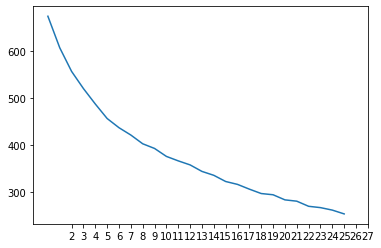

In [13]:
plt.plot(inertia_scores)
plt.xticks(range(2, 28), [str(i) for i in range(2, 28)]);

The ideal number of clusters is not obvious from the elbow plot. We'll instead see if the Sihouette Method provides more fruitful results.

For n_clusters = 2 The average silhouette_score is : 0.13890092987581293
For n_clusters = 3 The average silhouette_score is : 0.1362553443101158
For n_clusters = 4 The average silhouette_score is : 0.1643502840102735
For n_clusters = 5 The average silhouette_score is : 0.16358103207370916
For n_clusters = 6 The average silhouette_score is : 0.14604061518290368
For n_clusters = 7 The average silhouette_score is : 0.15438131513250666
For n_clusters = 8 The average silhouette_score is : 0.1507100604336832
For n_clusters = 9 The average silhouette_score is : 0.15643227173413626
For n_clusters = 10 The average silhouette_score is : 0.15949051815620627
For n_clusters = 11 The average silhouette_score is : 0.1566873282261171
For n_clusters = 12 The average silhouette_score is : 0.16081562029644575
For n_clusters = 13 The average silhouette_score is : 0.15067086676948793
For n_clusters = 14 The average silhouette_score is : 0.15475594888346159
For n_clusters = 15 The average silhouette_score i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


For n_clusters = 22 The average silhouette_score is : 0.18743150465148678


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


For n_clusters = 23 The average silhouette_score is : 0.17869838763128143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


For n_clusters = 24 The average silhouette_score is : 0.194818632499883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


For n_clusters = 25 The average silhouette_score is : 0.19459077096370403


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


For n_clusters = 26 The average silhouette_score is : 0.18396913263716888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


For n_clusters = 27 The average silhouette_score is : 0.18834036652195826


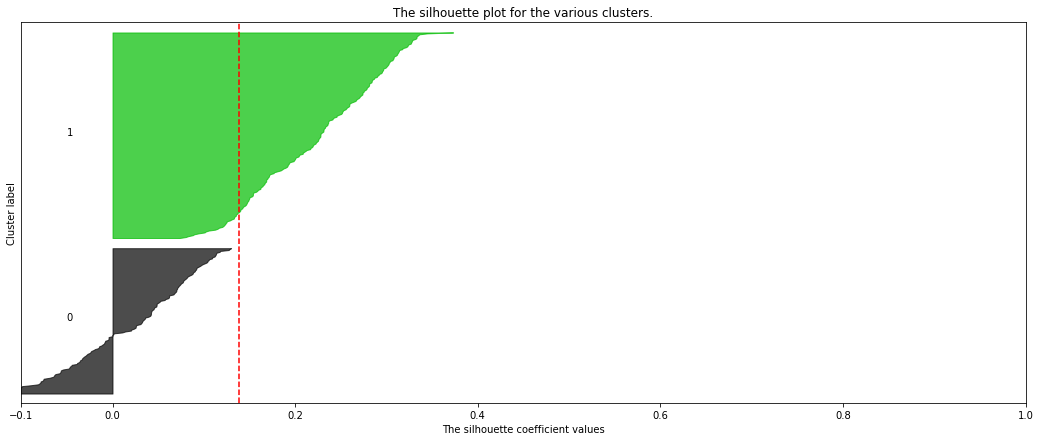

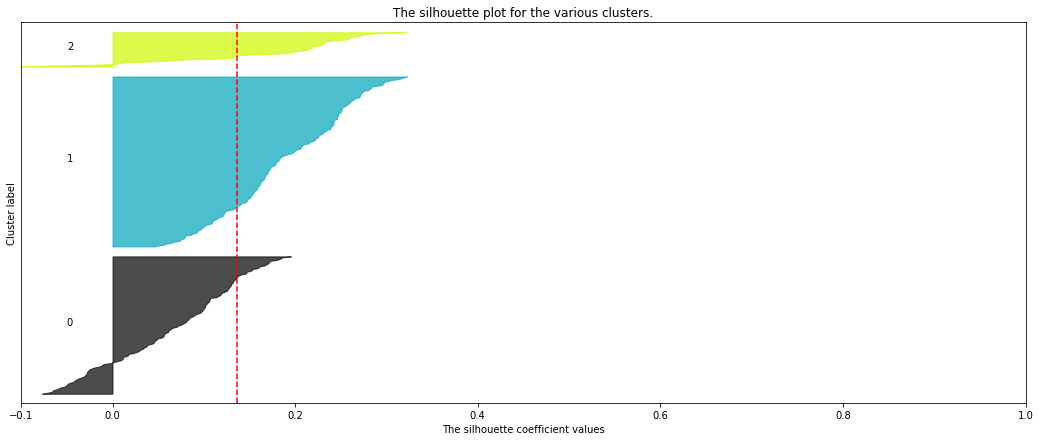

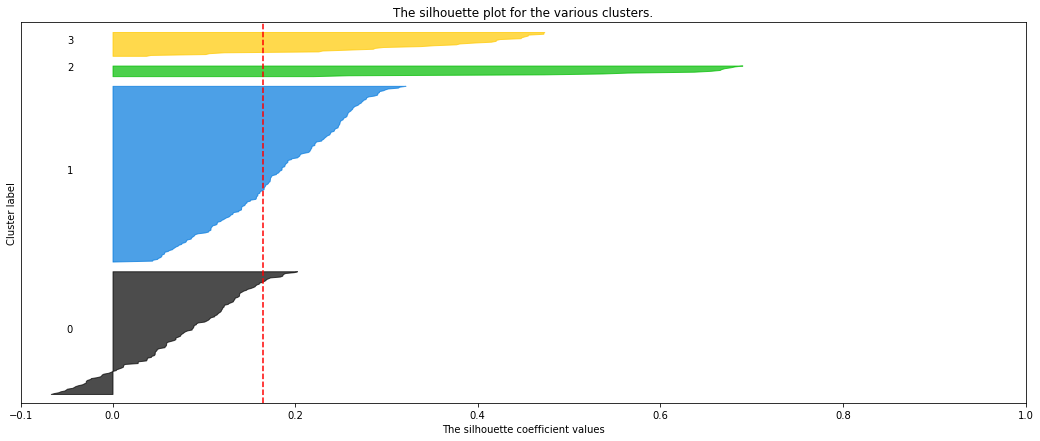

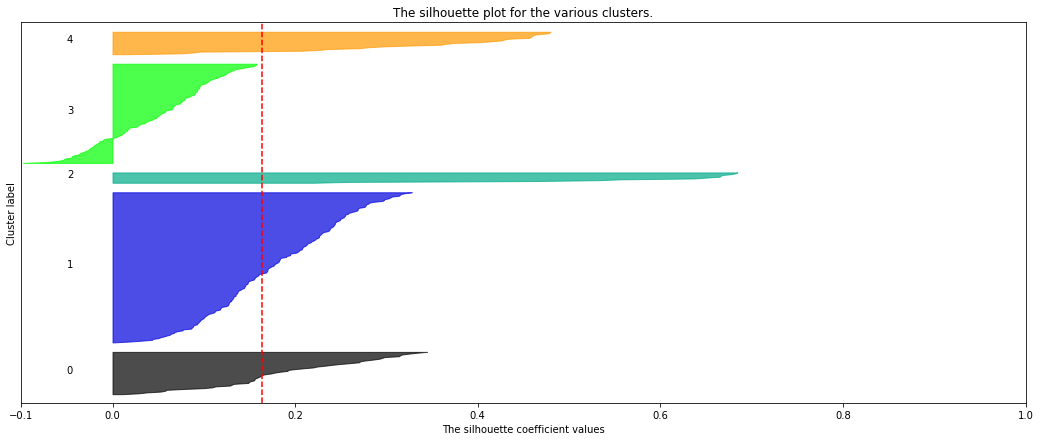

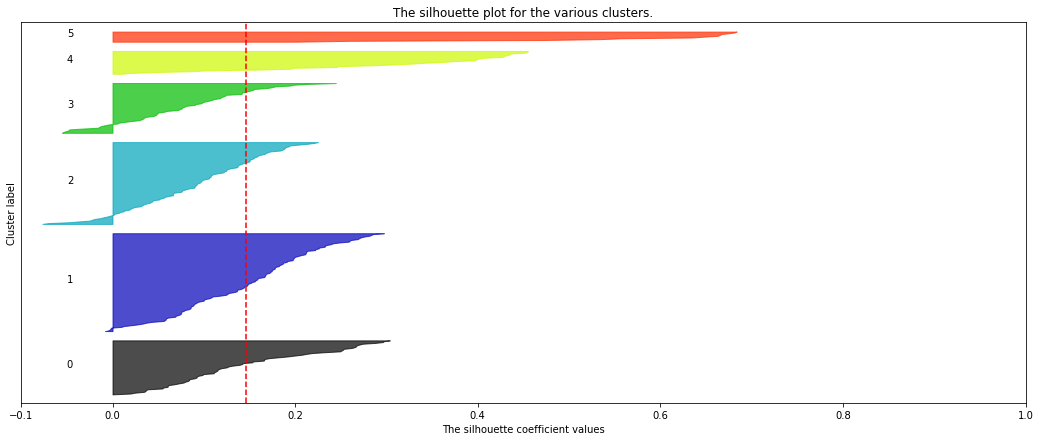

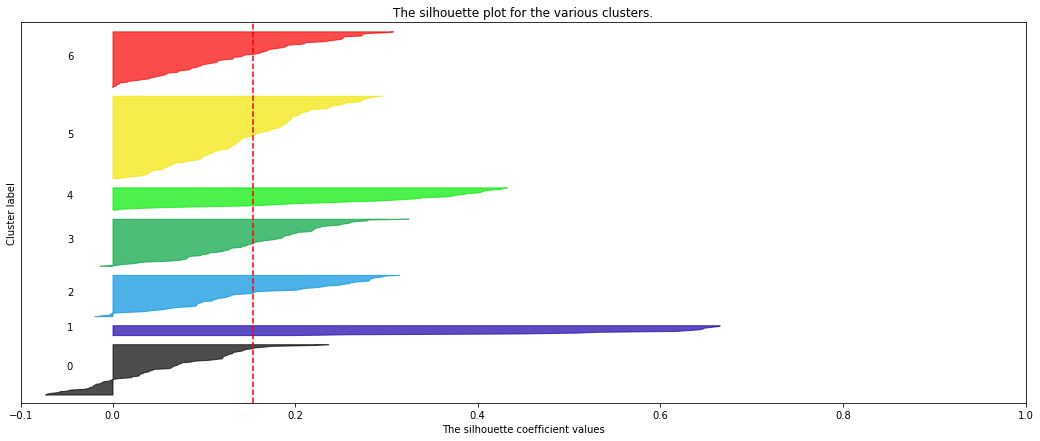

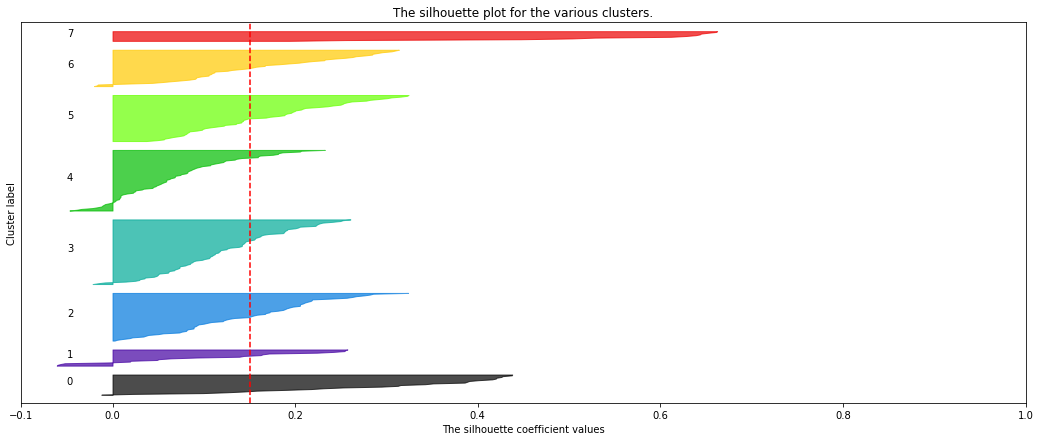

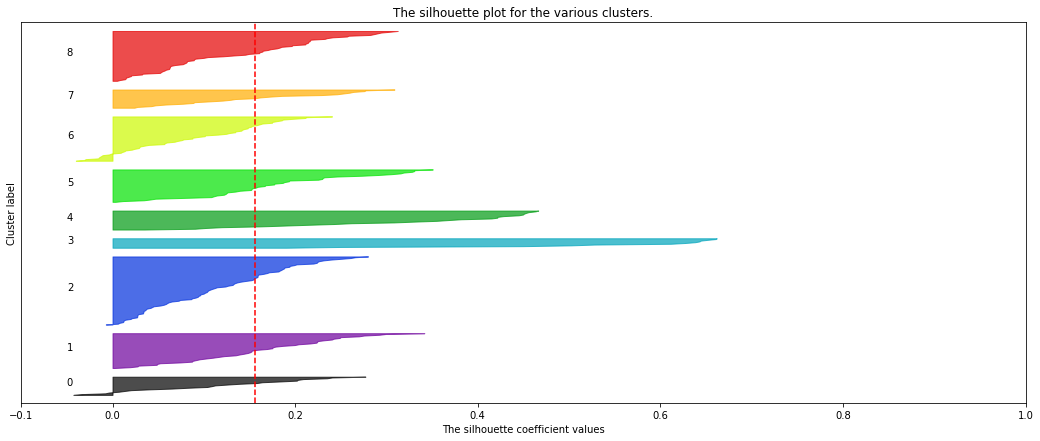

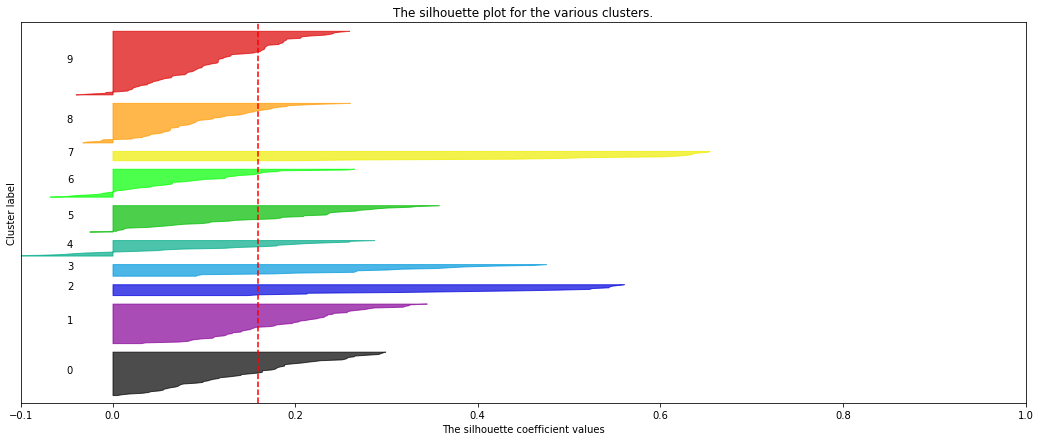

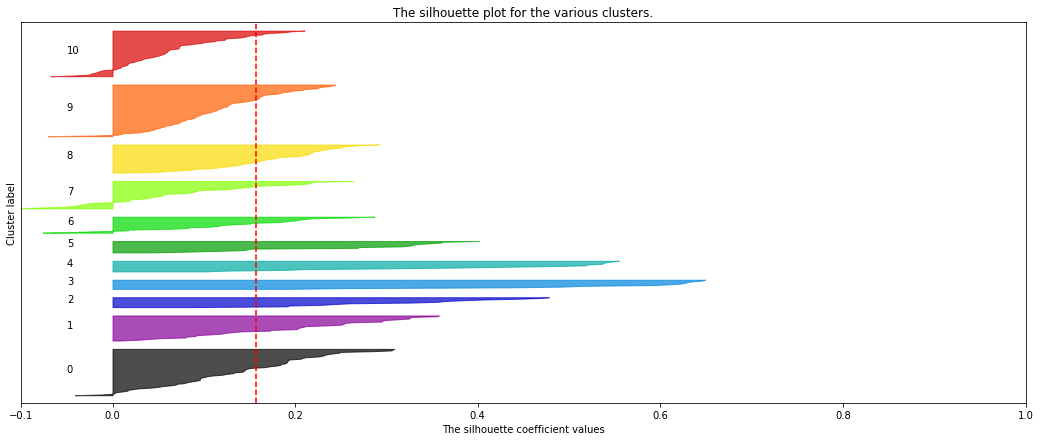

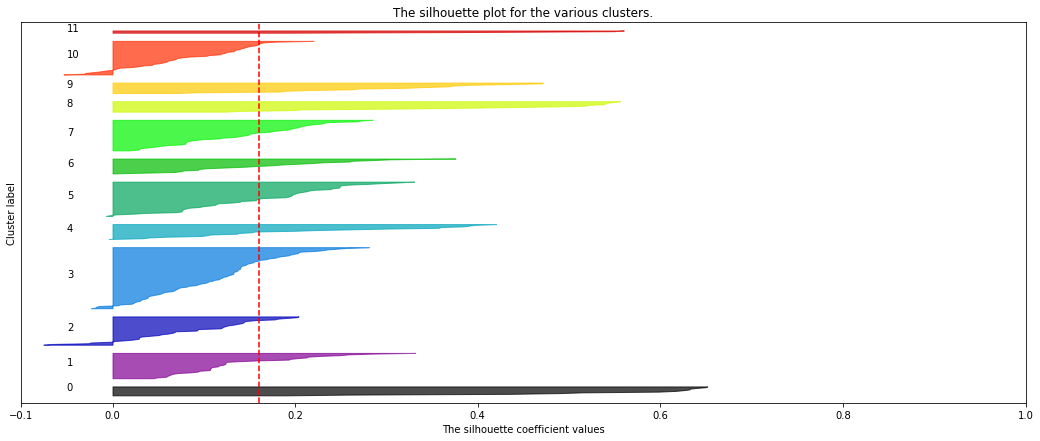

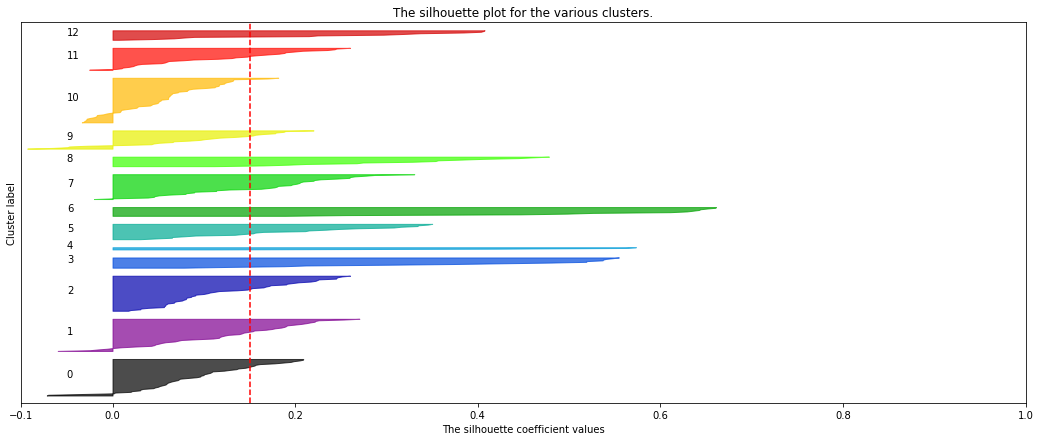

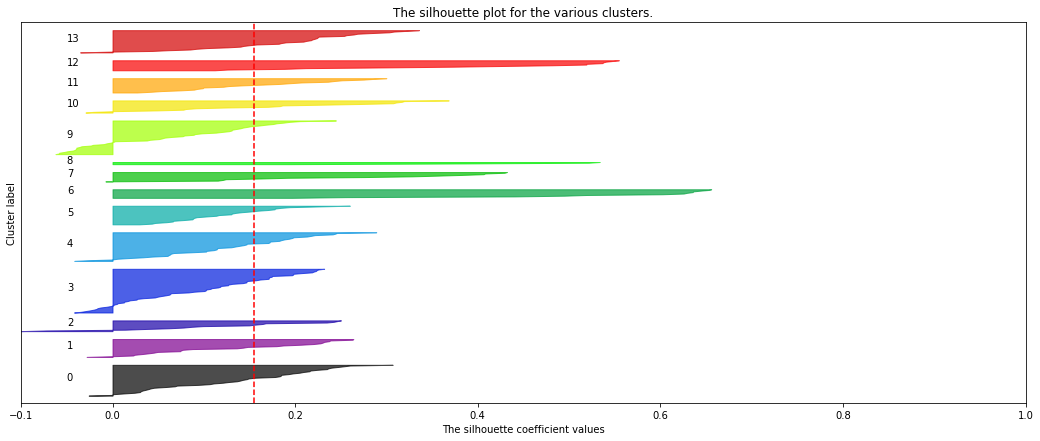

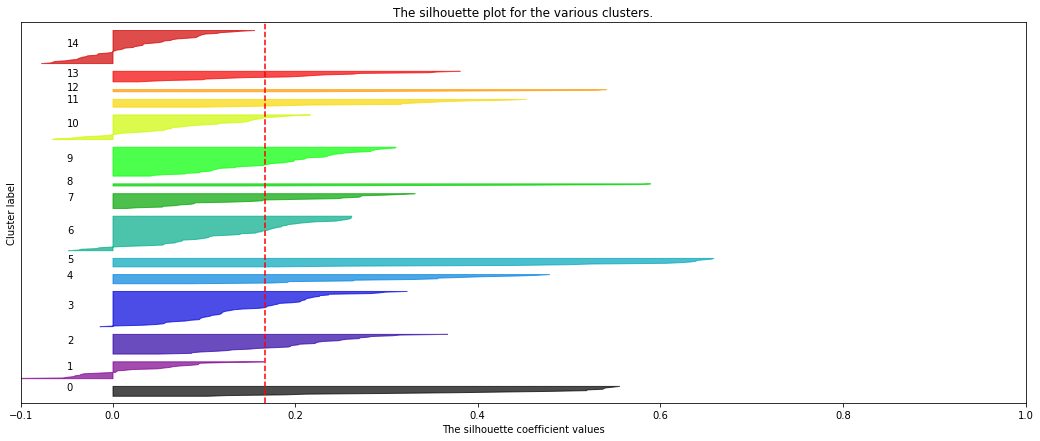

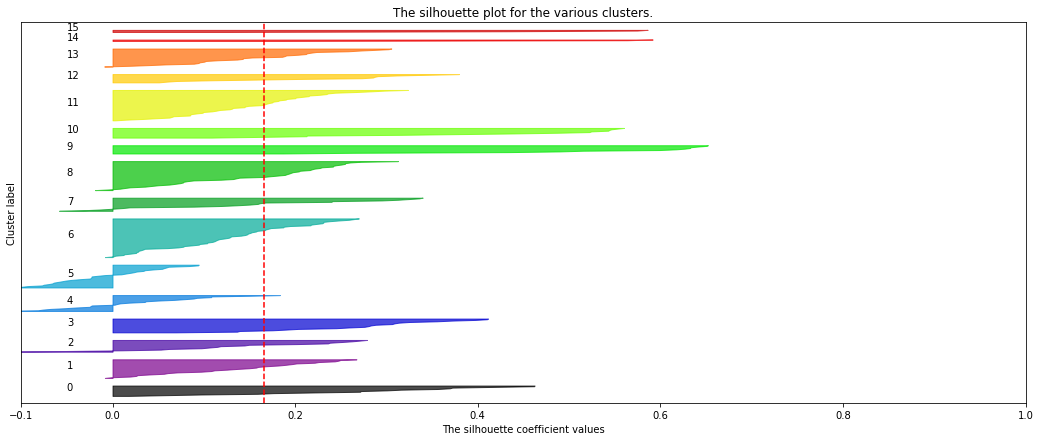

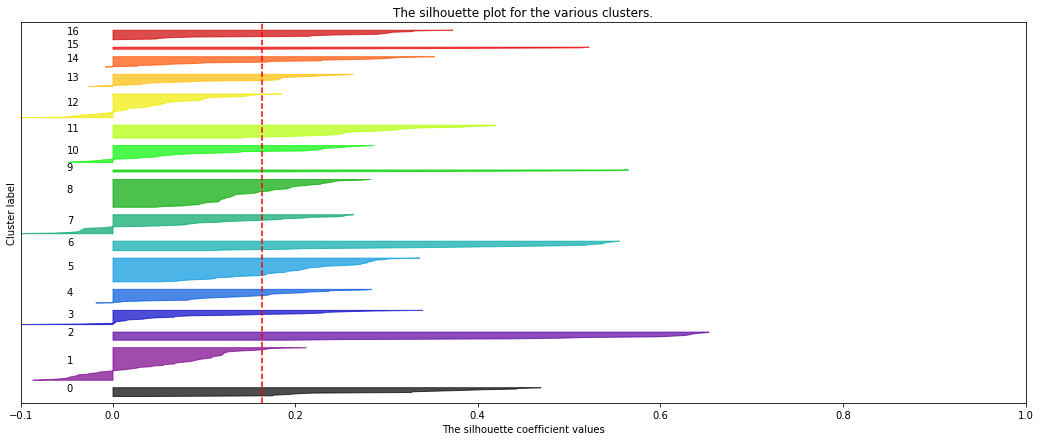

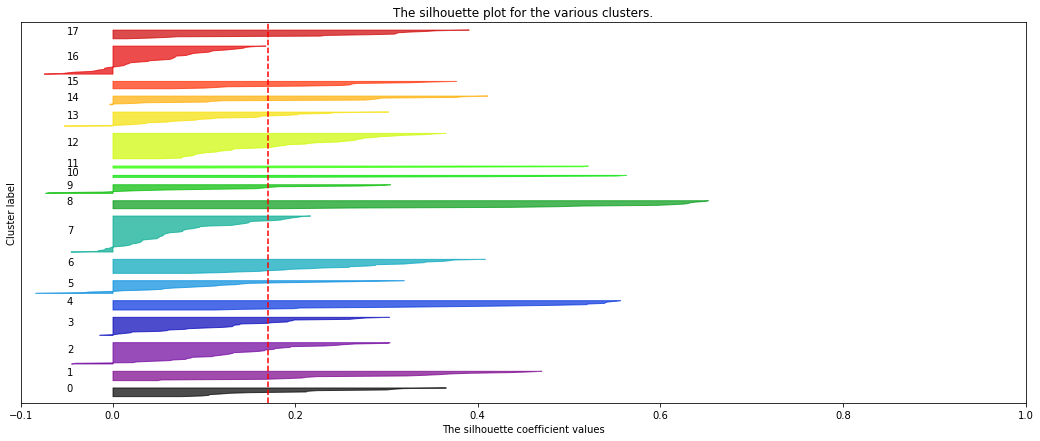

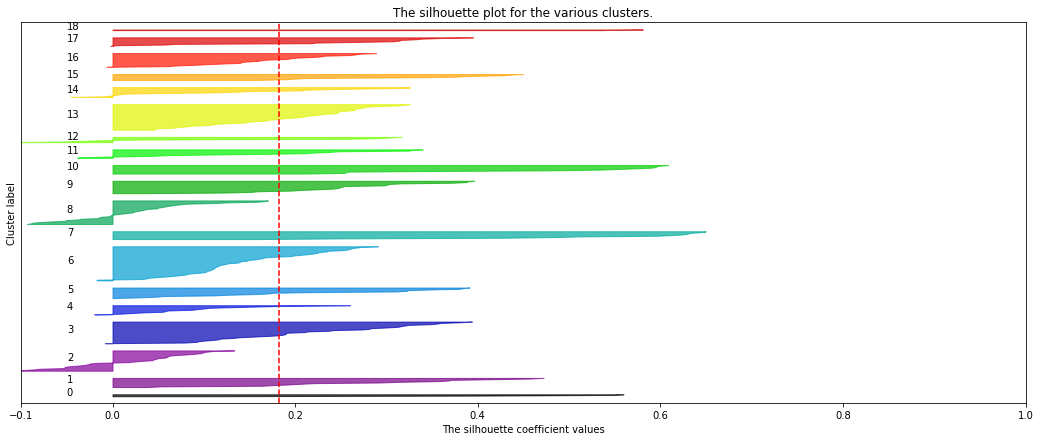

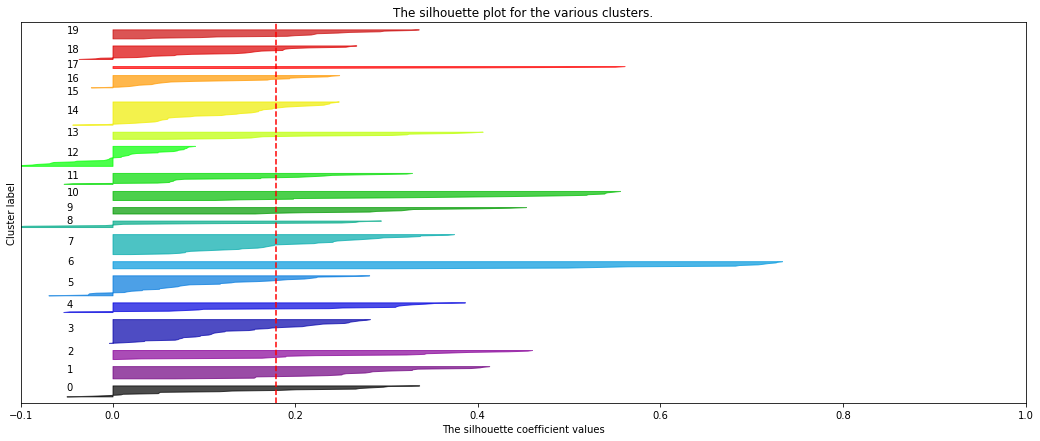

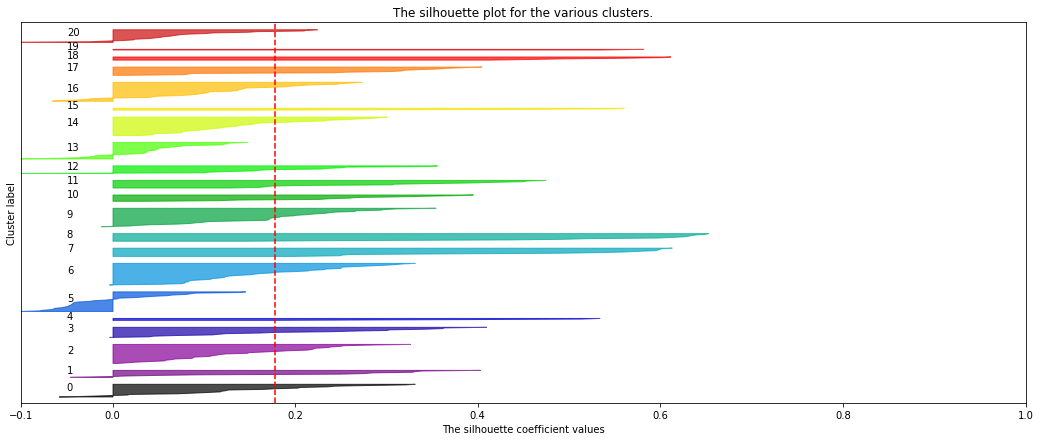

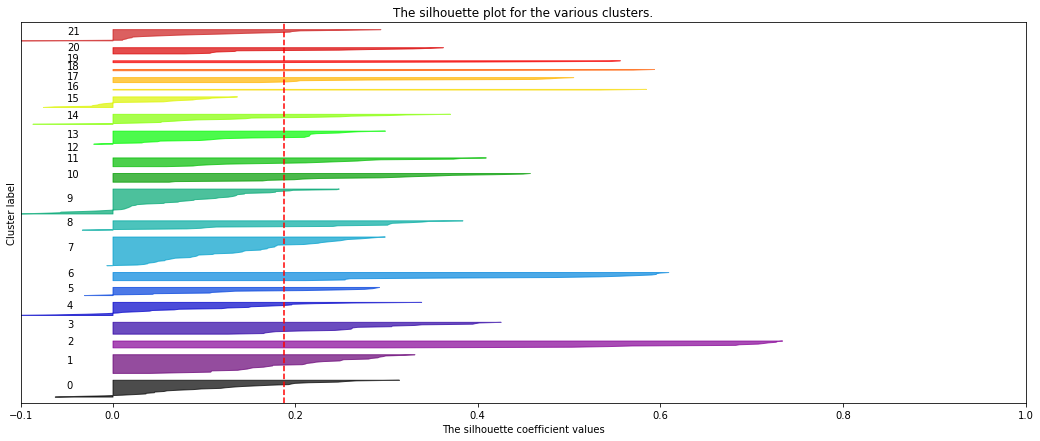

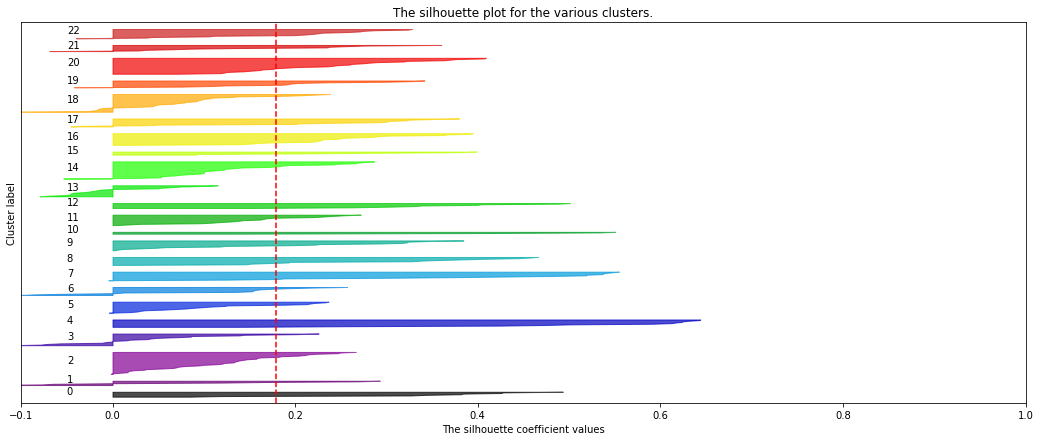

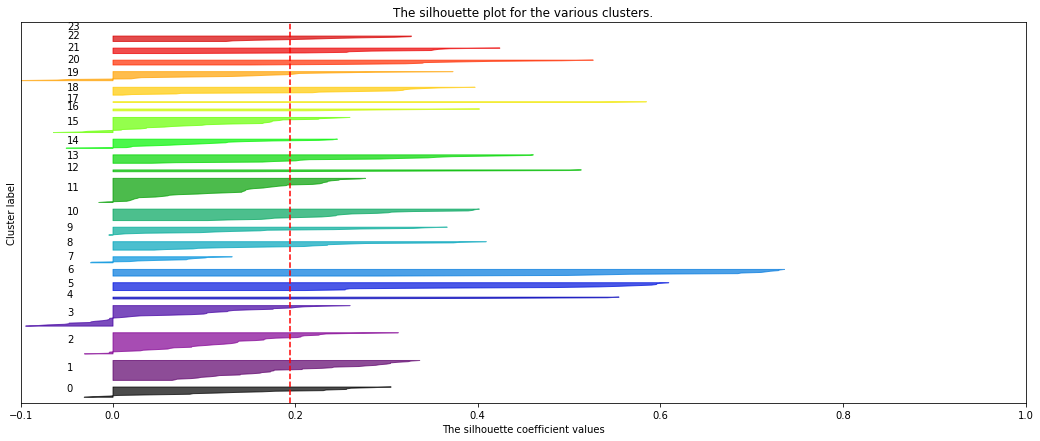

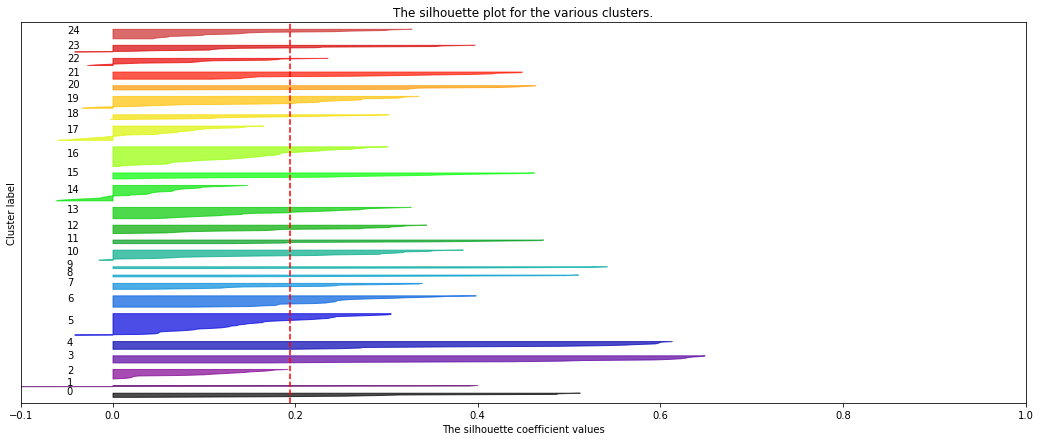

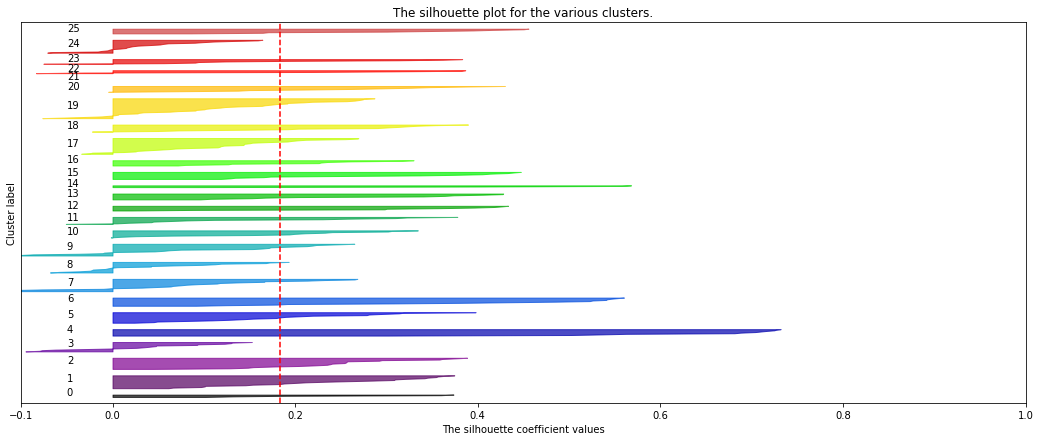

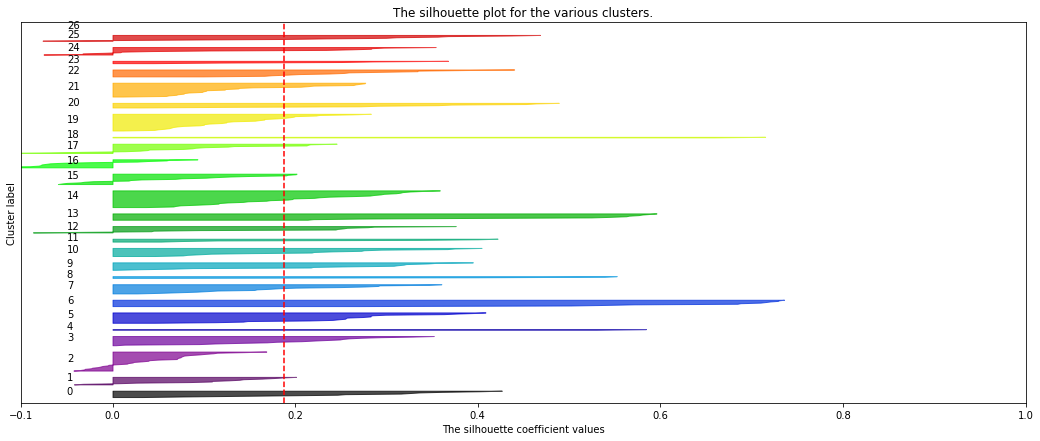

In [14]:
range_n_clusters = range(2, 28)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(feature_set) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=25)
    cluster_labels = clusterer.fit_predict(feature_set)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(feature_set, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(feature_set, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

24 Clusters seems to provide tbe best results so we'll go with that.

In [15]:
# Fit the K Means clustering algorithm get the cluster assignments for each attribute
km = KMeans(n_clusters=24, random_state=25)
km.fit(feature_set)
labels = km.predict(feature_set)
attribute_assignments = pd.Series(labels, index=game_categories)

In [16]:
attribute_assignments

Action                 1
Casual                15
Indie                  1
Simulation             1
Strategy               1
                      ..
Wrestling             18
360 Video              6
Faith                 13
Bikes                 23
Mods (require HL1)     4
Length: 381, dtype: int32

Let's look at the groupings for each attribute

In [17]:
for i in range(24):
  cluster = attribute_assignments[attribute_assignments == i]
  print("Cluster {0}: {1}".format(i, ",".join(cluster.index)))

Cluster 0: Moddable,Trading,City Builder,Building,Economy,Base Building,Sandbox,Management,Space,Political,Agriculture,Space Sim,Capitalism,Politics,Resource Management,God Game,Fishing,Mining
Cluster 1: Action,Indie,Simulation,Strategy,Single-player,RPG,Multi-player,Online Multi-Player,Cross-Platform Multiplayer,Steam Achievements,Steam Trading Cards,Stats,Adventure,Full controller support,Downloadable Content,Steam Cloud,Steam Leaderboards,Partial Controller Support,Early Access,Shared/Split Screen,Valve Anti-Cheat enabled,Steam Turn Notifications,Co-op,Violent,Commentary available,Steam Workshop,Includes level editor,Western,Flight,Tower Defense,Game demo,On-Rails Shooter,Soundtrack,Pinball
Cluster 2: 2D,Replay Value,Difficult,Pixel Graphics,Cute,Singleplayer,Great Soundtrack,Retro,Platformer,Side Scroller,Stylized,Arcade,Underground,Remake,Action-Adventure,Spectacle fighter,Character Action Game,Beat 'em up,Controller,Fast-Paced,2.5D,Ninja,Puzzle-Platformer,Time Attack,Colorful,3D 